## Figure 6: MNIST Example

Creates figure 6 from 'Meta-Learning the Inductive Bias of Simple Neural Circuits', Dorrell et al. 2022.

We meta-learn a labelling of the MNIST 0 and 1 digits that is easy to generalise.

In [1]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function that lets us update the pytorch parameters in place, while still allowing gradients to flow through these updates
def update_module(module, updates=None, memo=None):
    r"""
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/utils.py)
    **Description**
    Updates the parameters of a module in-place, in a way that preserves differentiability.
    The parameters of the module are swapped with their update values, according to:
    \[
    p \gets p + u,
    \]
    where \(p\) is the parameter, and \(u\) is its corresponding update.
    **Arguments**
    * **module** (Module) - The module to update.
    * **updates** (list, *optional*, default=None) - A list of gradients for each parameter
        of the model. If None, will use the tensors in .update attributes.
    **Example**
    ~~~python
    error = loss(model(X), y)
    grads = torch.autograd.grad(
        error,
        model.parameters(),
        create_graph=True,
    )
    updates = [-lr * g for g in grads]
    l2l.update_module(model, updates=updates)
    ~~~
    """
    if memo is None:
        memo = {}
    if updates is not None:
        params = list(module.parameters())
        if not len(updates) == len(list(params)):
            msg = 'WARNING:update_module(): Parameters and updates have different length. ('
            msg += str(len(params)) + ' vs ' + str(len(updates)) + ')'
            print(msg)
        for p, g in zip(params, updates):
            p.update = g

    # Update the params
    for param_key in module._parameters:
        p = module._parameters[param_key]
        if p is not None and hasattr(p, 'update') and p.update is not None:
            if p in memo:
                module._parameters[param_key] = memo[p]
            else:
                updated = p + p.update
                memo[p] = updated
                module._parameters[param_key] = updated

    # Second, handle the buffers if necessary
    for buffer_key in module._buffers:
        buff = module._buffers[buffer_key]
        if buff is not None and hasattr(buff, 'update') and buff.update is not None:
            if buff in memo:
                module._buffers[buffer_key] = memo[buff]
            else:
                updated = buff + buff.update
                memo[buff] = updated
                module._buffers[buffer_key] = updated

    # Then, recurse for each submodule
    for module_key in module._modules:
        module._modules[module_key] = update_module(
            module._modules[module_key],
            updates=None,
            memo=memo,
        )

    # Finally, rebuild the flattened parameters for RNNs
    # See this issue for more details:
    # https://github.com/learnables/learn2learn/issues/139
    if hasattr(module, 'flatten_parameters'):
        module._apply(lambda x: x)
    return module

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)

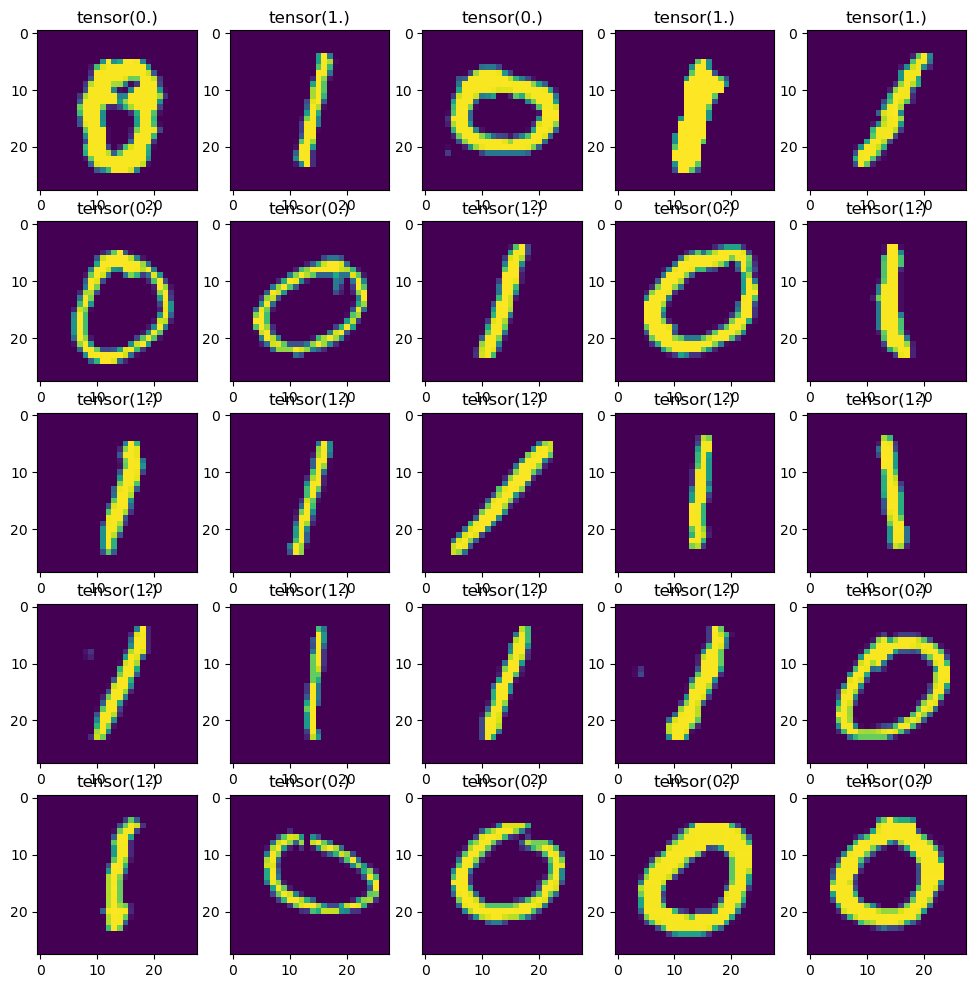

In [6]:
# Clean up and get my own version of the dataset
N_Total = 2000
Images = torch.zeros([N_Total, 28, 28])
Labels = torch.zeros([N_Total, 2])
Labels_mnist = torch.zeros([N_Total])
count = 0

for (i, data) in enumerate(loader):
    if count < N_Total:
        x, y = data
        if y < 2:
            Images[count,:,:] = x#torch.flatten(x)
            Labels[count, int(y%2)] = 1
            Labels_mnist[count] = y
            count = count + 1
        
plt.figure(figsize = (12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    #plt.imshow(torch.reshape(Images[i,:], [28,28]))
    plt.imshow(Images[i,:,:])
    #plt.title(Labels[i,:])
    plt.title(Labels_mnist[i])

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        #self.conv2 = nn.Sequential(         
        #    nn.Conv2d(16, 32, 5, 1, 2),     
        #    nn.ReLU(),                      
        #    nn.MaxPool2d(2),                
        #)
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 14 * 14, 1)
        self.tanh = nn.Tanh()
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        #output = self.ReLU(output)
        return output    # return x for visualization

In [9]:
class MetaNet(nn.Module):
    def __init__(self):
        super(MetaNet, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 1)
        self.relu = nn.ReLU()
        self.relu6 = nn.ReLU6(inplace=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        output = self.relu6(output)/6
        return output    # return x for visualization

In [12]:
# Set up meta-learner and training procedure
meta_learner = MetaNet()
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.001)
T = 30 # Number of meta steps
M = 300 # Test points per meta step
m = 20 # Batch size
t = 100 # Number of inner training steps
m_train = 600

# Some admin
min_loss = 1000000
loss_fcn = nn.MSELoss()

for meta_step in range(T):
    meta_optimizer.zero_grad()
    z = meta_learner(Images[:,None,:,:])

    learner = CNN()
    optimizer = torch.optim.Adam(learner.parameters(), lr = 0.01)

    for i in range(t):
        train_index = np.random.choice(m_train, m)
        optimizer.zero_grad()
        z_l = learner(Images[train_index,None,:,:])

        loss = loss_fcn(z_l, z[train_index,:])
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        updates = list(map(lambda x: -0.0025*x, g))       
        learner = update_module(learner, updates)

        if i%20 == 0:
            print(f"{meta_step/T}, {i/t}, loss = {loss}")
        
    if torch.isnan(loss):
        print(z)
    # Measure generalisation error and distribution loss
    z_test_l = learner(Images[m_train:,None,:,:])
    ent_loss = torch.std(z)
    l_class = loss_fcn(z_test_l, z[m_train:,:])
    meta_loss = l_class - 100*ent_loss
    meta_loss.backward()
    meta_optimizer.step()

    if meta_loss < min_loss:
        meta_learner_best = meta_learner
        min_loss = meta_loss
    
    if meta_step % 1 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss:0.2f}, Loss_g: {l_class:0.4f}, Loss_e: {ent_loss:.4f}")    

0.0, 0.0, loss = 0.015771061182022095
0.0, 0.2, loss = 0.03833548352122307
0.0, 0.4, loss = 0.006136767566204071
0.0, 0.6, loss = 0.014841713011264801
0.0, 0.8, loss = 0.0036692738067358732
Meta-Step: 0/30, Meta-Loss: -0.19, Loss_g: 0.0043, Loss_e: 0.0020
0.03333333333333333, 0.0, loss = 0.004223519936203957
0.03333333333333333, 0.2, loss = 0.042208004742860794
0.03333333333333333, 0.4, loss = 0.00600484199821949
0.03333333333333333, 0.6, loss = 0.0055760727263987064
0.03333333333333333, 0.8, loss = 0.002907967660576105
Meta-Step: 1/30, Meta-Loss: -1.60, Loss_g: 0.0034, Loss_e: 0.0161
0.06666666666666667, 0.0, loss = 0.014205748215317726
0.06666666666666667, 0.2, loss = 2.183366298675537
0.06666666666666667, 0.4, loss = 0.005658221431076527
0.06666666666666667, 0.6, loss = 0.004024233669042587
0.06666666666666667, 0.8, loss = 0.0023927141446620226
Meta-Step: 2/30, Meta-Loss: -3.25, Loss_g: 0.0035, Loss_e: 0.0325
0.1, 0.0, loss = 0.043790120631456375
0.1, 0.2, loss = 0.00217801285907626

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


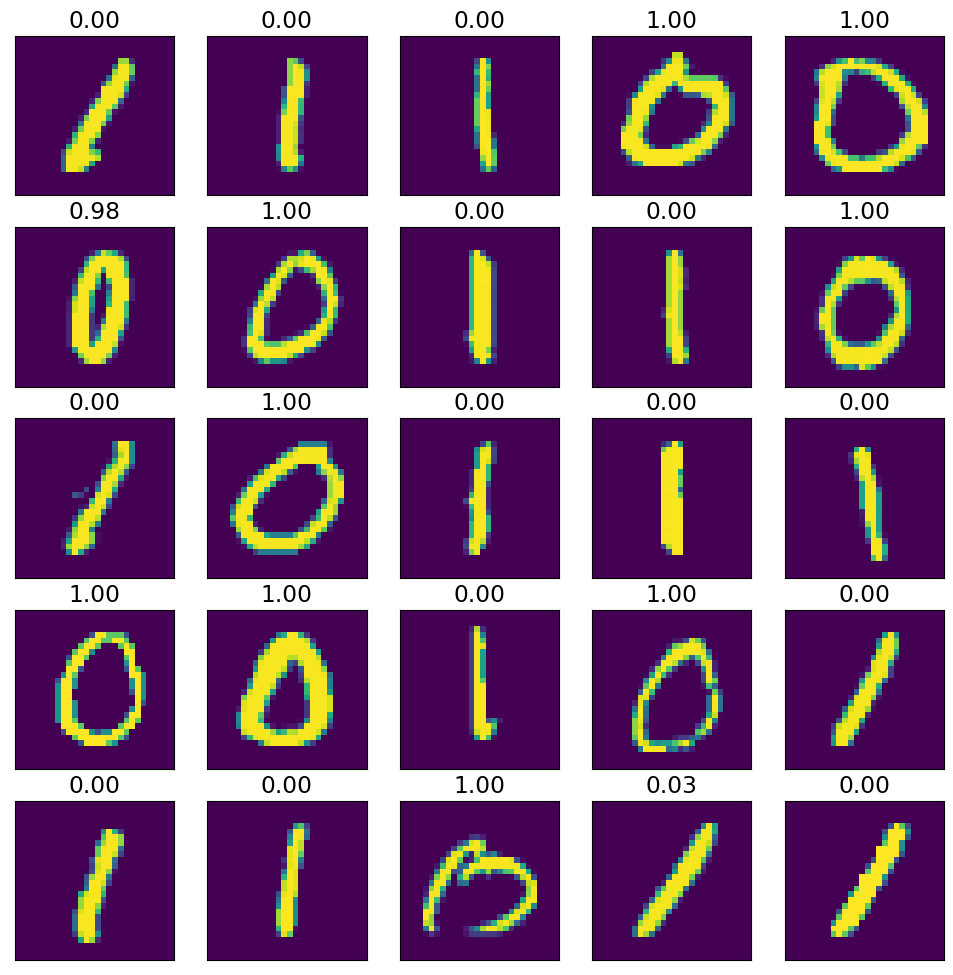

In [13]:
plt.figure(figsize = (12,12))
shift = 800


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Images[i+shift,:,:])
    #plt.title(f"{np.argmax(meta_learner(Images[i,:,:][None,None,:,:]).detach().numpy())}")
    #plt.title(f"{meta_learner(Images[i+shift,:,:][None,None,:,:]).detach().numpy()[0,0]:.2f}, {meta_learner(Images[i+shift,:,:][None,None,:,:]).detach().numpy()[0,1]:.2f}")
    plt.title(f"{meta_learner(Images[i+shift,:,:][None,None,:,:]).detach().numpy()[0,0]:.2f}")
    
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    

In [14]:
z_plot = np.zeros([N_Total])
for i in range(N_Total):
    z_plot[i] = meta_learner(Images[i,:,:][None,None,:,:]).detach().numpy()[0,0]
Labels_np = Labels_mnist.detach().numpy()


In [15]:
Labels_np_II = np.zeros(Labels_np.size)
for i in range(N_Total):
    Labels_np_II[i] = (1 - Labels_np[i])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


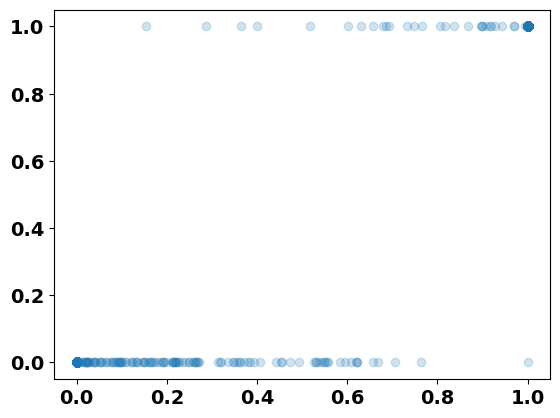

In [16]:
z_plot = z.detach().numpy()
plt.scatter(z_plot, Labels_np_II, alpha = 0.2)


(array([1.894e+03, 3.200e+01, 2.400e+01, 1.900e+01, 7.000e+00, 1.200e+01,
        7.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

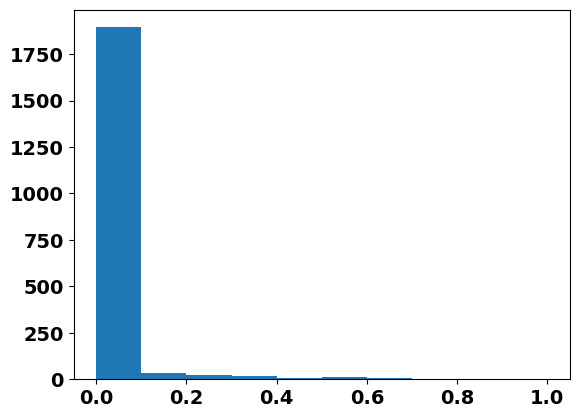

In [17]:
plt.hist(np.abs(np.ndarray.flatten(z_plot) - np.ndarray.flatten(Labels_np_II)), 10)

In [18]:
Labels_np = Labels.detach().numpy()

In [19]:
plt.figure(figsize = (12,12))

count = 1
for (i, image) in enumerate(Images):
    if abs(z_plot[i] - Labels_np[i]) > 0.4:
        plt.subplot(5, 5, count)
        plt.imshow(image)
        plt.title(f"{z_plot[i][0]:.2f}")
        count = count + 1
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1200x1200 with 0 Axes>

In [ ]:
z[Label_assign[:,class_ind], 1].shape

In [ ]:
Label_assign = Labels > 0.9
for class_ind in range(2):
    plt.scatter(z_plot[Label_assign[:,class_ind], 0], z_plot[Label_assign[:,class_ind], 1])

In [ ]:
Labels > 0.9

In [ ]:
plt.figure(figsize = (12,12))
shift = 800
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Images[i+shift,:,:])
    #plt.title(f"{np.argmax(meta_learner(Images[i,:,:][None,None,:,:]).detach().numpy())}")
    plt.title(f"{meta_learner(Images[i+shift,:,:][None,None,:,:]).detach().numpy()[0,0]:.2f}, {meta_learner(Images[i+shift,:,:][None,None,:,:]).detach().numpy()[0,1]:.2f}")
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)